# Preciting Introvert or Extrovert

### Libraries Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import xgboost as xgb

from sklearn.manifold import TSNE as sklearn_TSNE

import optuna
import torch
import copy
import itertools
import warnings

warnings.filterwarnings('ignore')

In [4]:
import os
for dirname, _, filenames in os.walk('./input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/test.csv
./input/train.csv


### Data Import & Info

In [6]:
df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")

In [7]:
df_train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [8]:
df_test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [10]:
# Any Missing values ?
print('Train columns with null values:\n', df_train.isnull().sum())
print("-"*50)
print('Test columns with null values:\n', df_test.isnull().sum())

Train columns with null values:
 id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64
--------------------------------------------------
Test columns with null values:
 id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


In [11]:
round(df_train['Personality'].value_counts(normalize=True)*100)

Personality
Extrovert    74.0
Introvert    26.0
Name: proportion, dtype: float64

In [12]:
df_train.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

### Data Encoding

In [14]:
## Cat & Num Columns
cat_cols = ['Stage_fear', 'Drained_after_socializing']
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']

## Categorical Columns - LabelEncoder()
le_fear = LabelEncoder()
le_social = LabelEncoder()

## Deal with missing values
### Numerical Columns - fillna by mean()

### Categorical Columns - fillna("Missing")

## Use of encode
for df in [df_train, df_test]:
    #df[num_cols] = np.round(df[num_cols].fillna(df[num_cols].mean()),0)
    df[cat_cols] = df[cat_cols].fillna("missing")
    df['Stage_fear'] = le_fear.fit_transform(df['Stage_fear'])
    df['Drained_after_socializing'] = le_social.fit_transform(df['Drained_after_socializing'])

In [15]:
le_pers = LabelEncoder()
df_train['Personality'] = le_pers.fit_transform(df_train['Personality'])

In [16]:
df_train.describe(include='all')

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,18524.000000,17334.000000,18524.000000,17344.000000,17058.000000,18524.000000,17470.000000,17260.000000,18524.000000
mean,9261.500000,3.137764,0.421507,5.265106,4.044319,0.343338,7.996737,4.982097,0.260473
std,5347.562529,3.003786,0.669512,2.753359,2.062580,0.591212,4.223484,2.879139,0.438905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000,0.000000
50%,9261.500000,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000,0.000000
75%,13892.250000,4.000000,1.000000,8.000000,6.000000,1.000000,12.000000,7.000000,1.000000
max,18523.000000,11.000000,2.000000,10.000000,7.000000,2.000000,15.000000,10.000000,1.000000


### Data Visualization

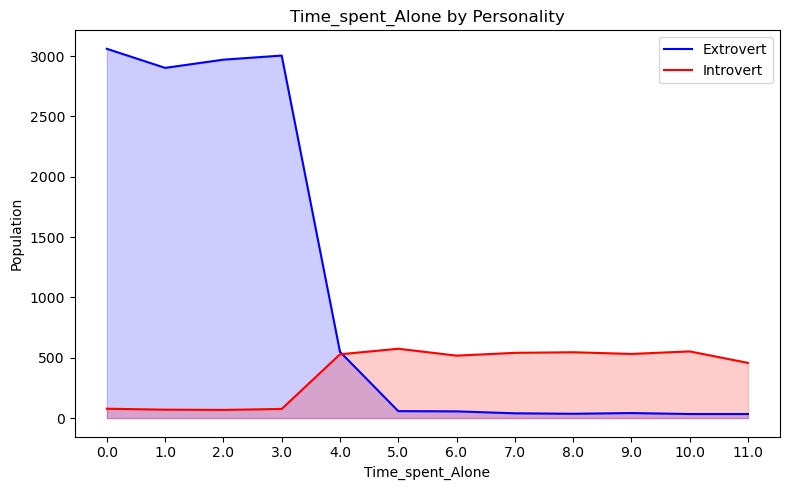

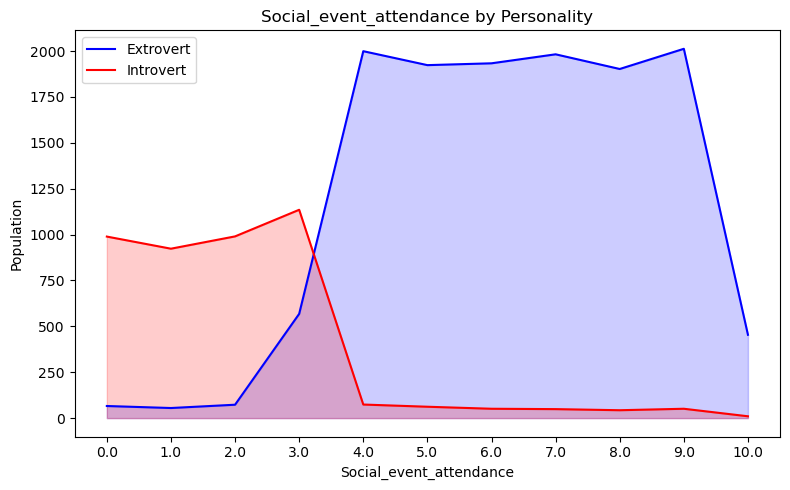

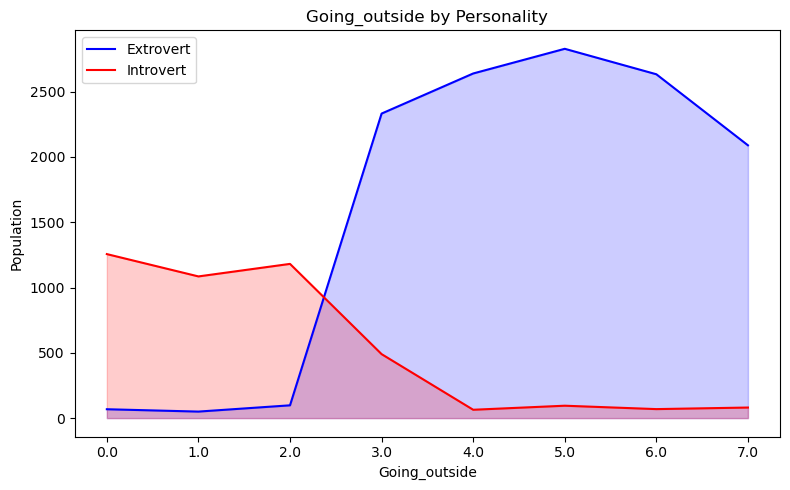

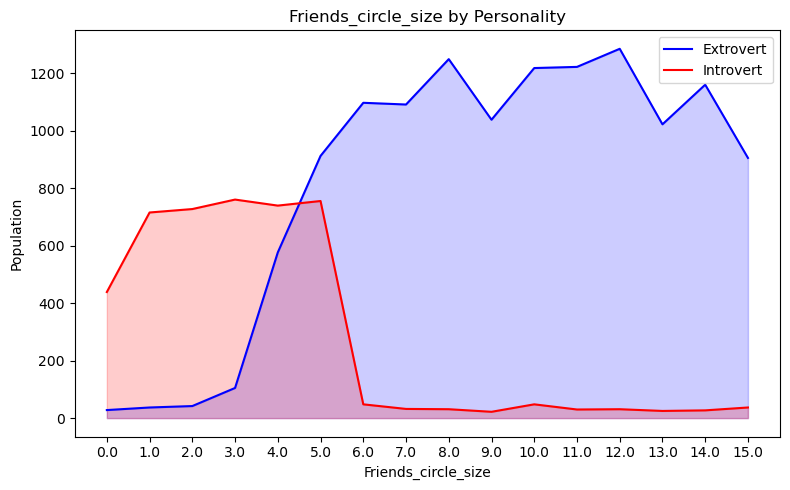

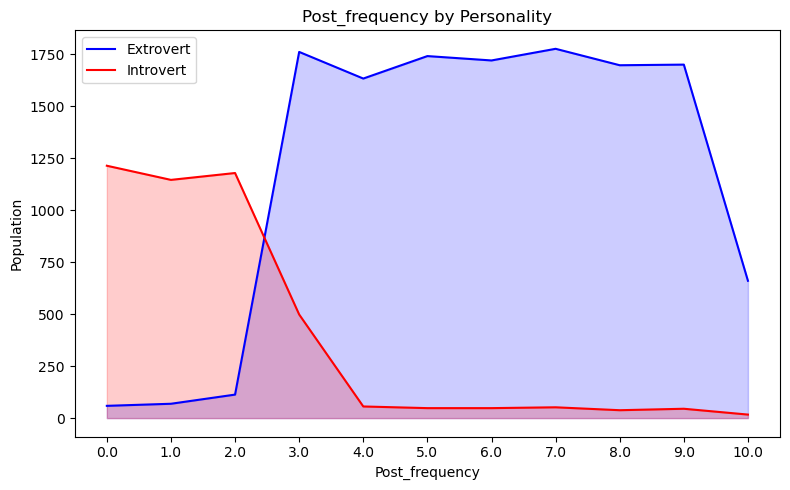

In [18]:
cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']

features = [col for col in cols if col != 'Personality']

for col in features:
    # create table for each columns by TARGET
    count_data = df_train.groupby([col, 'Personality']).size().reset_index(name='count')
    pivot = count_data.pivot(index=col, columns='Personality', values='count').fillna(0)

    # Category order
    categories = pivot.index.tolist()
    x = range(len(categories))

    plt.figure(figsize=(8, 5))

    # Extrovert line
    if 0 in pivot.columns:
        y0 = np.round(pivot[0].values,0)
        sns.lineplot(x=x, y=y0, label='Extrovert', color='blue')
        plt.fill_between(x, y0, color='blue', alpha=0.2)

    # Introvert line
    if 1 in pivot.columns:
        y1 = np.round(pivot[1].values,0)
        sns.lineplot(x=x, y=y1, label='Introvert', color='red')
        plt.fill_between(x, y1, color='red', alpha=0.2)

    # Plot display
    plt.xticks(ticks=x, labels=categories)
    plt.title(f'{col} by Personality')
    plt.xlabel(col)
    plt.ylabel('Population')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
# Any Missing values ?
print('Train columns with null values:\n', df_train.isnull().sum())
print("-"*50)
print('Test columns with null values:\n', df_test.isnull().sum())

Train columns with null values:
 id                              0
Time_spent_Alone             1190
Stage_fear                      0
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing       0
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64
--------------------------------------------------
Test columns with null values:
 id                             0
Time_spent_Alone             425
Stage_fear                     0
Social_event_attendance      397
Going_outside                466
Drained_after_socializing      0
Friends_circle_size          350
Post_frequency               408
dtype: int64


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 18524 non-null  int32  
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  18524 non-null  int32  
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  int32  
dtypes: float64(5), int32(3), int64(1)
memory usage: 1.1 MB


In [ ]:
def correlation_with_target(df, target_col='Personality', top_n=None, plot=True):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()
    target_corr = corr_matrix[target_col].drop(labels=[target_col])
    target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)
    print(f"\n Correlations with target column ({target_col}) :\n")    
    return target_corr_sorted

correlation_with_target(df_train)


✅ Corrélations with target column (Personality) :



Time_spent_Alone             0.776725
Drained_after_socializing    0.737216
Going_outside               -0.708869
Social_event_attendance     -0.702879
Post_frequency              -0.678355
Friends_circle_size         -0.657216
Stage_fear                   0.595300
id                           0.001475
Name: Personality, dtype: float64

In [22]:
X_train = df_train.drop(['Personality'], axis=1)
y_train = df_train['Personality']
X_test = df_test.copy()

In [23]:
X_train = X_train.drop(['id'], axis=1)
X_test = X_test.drop(['id'], axis=1)

## Logistic Regression

## XGBClassifier

In [ ]:
# KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna objective
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 1e-8, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha',1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        "tree_method": trial.suggest_categorical('tree_method', ['approx', 'auto', 'hist']),
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
    }

    auc_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train[train_idx], y_train[valid_idx]        

        model_xgb = XGBClassifier(**params, early_stopping_rounds=10, verbose=False)
        model_xgb.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)]
        )

        y_pred_valid = model_xgb.predict_proba(X_val)[:, 1]
        y_pred_train = model_xgb.predict_proba(X_tr)[:, 1]
        auc_valid = roc_auc_score(y_val, y_pred_valid)
        auc_train = roc_auc_score(y_tr, y_pred_train)
        overfit = auc_train - auc_valid

    return auc_valid, overfit

# Optuna
study_xgb = optuna.create_study(directions=["maximize", "minimize"])
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2025-07-10 23:08:53,212] A new study created in memory with name: no-name-760e0efa-c50e-436d-9ba8-b88cbd39ee20


[0]	validation_0-logloss:0.44589
[1]	validation_0-logloss:0.36892
[2]	validation_0-logloss:0.31476
[3]	validation_0-logloss:0.27435
[4]	validation_0-logloss:0.24352
[5]	validation_0-logloss:0.21922
[6]	validation_0-logloss:0.20068
[7]	validation_0-logloss:0.18561
[8]	validation_0-logloss:0.17318
[9]	validation_0-logloss:0.16382
[10]	validation_0-logloss:0.15642
[11]	validation_0-logloss:0.15074
[12]	validation_0-logloss:0.14588
[13]	validation_0-logloss:0.14227
[14]	validation_0-logloss:0.13892
[15]	validation_0-logloss:0.13667
[16]	validation_0-logloss:0.13508
[17]	validation_0-logloss:0.13313
[18]	validation_0-logloss:0.13192
[19]	validation_0-logloss:0.13108
[20]	validation_0-logloss:0.13032
[21]	validation_0-logloss:0.12960
[22]	validation_0-logloss:0.12915
[23]	validation_0-logloss:0.12875
[24]	validation_0-logloss:0.12800
[25]	validation_0-logloss:0.12764
[26]	validation_0-logloss:0.12750
[27]	validation_0-logloss:0.12701
[28]	validation_0-logloss:0.12695
[29]	validation_0-loglos

[I 2025-07-10 23:08:54,700] Trial 0 finished with values: [0.9738257788573039, 0.0025182867037565337] and parameters: {'max_depth': 10, 'learning_rate': 0.16505822315743232, 'n_estimators': 180, 'subsample': 0.9995123662892899, 'colsample_bytree': 0.9841107822647343, 'colsample_bynode': 0.19373165545387716, 'min_child_weight': 3, 'gamma': 0.5903939743005274, 'reg_alpha': 0.5710770702556693, 'reg_lambda': 0.2576100010762943, 'tree_method': 'hist', 'lambda': 0.00010378561088552837}.


[0]	validation_0-logloss:0.56191
[1]	validation_0-logloss:0.54997
[2]	validation_0-logloss:0.53784
[3]	validation_0-logloss:0.52841
[4]	validation_0-logloss:0.51850
[5]	validation_0-logloss:0.50761
[6]	validation_0-logloss:0.49792
[7]	validation_0-logloss:0.48816
[8]	validation_0-logloss:0.47852
[9]	validation_0-logloss:0.46957
[10]	validation_0-logloss:0.46117
[11]	validation_0-logloss:0.45247
[12]	validation_0-logloss:0.44473
[13]	validation_0-logloss:0.43683
[14]	validation_0-logloss:0.42912
[15]	validation_0-logloss:0.42302
[16]	validation_0-logloss:0.41591
[17]	validation_0-logloss:0.40890
[18]	validation_0-logloss:0.40228
[19]	validation_0-logloss:0.39563
[20]	validation_0-logloss:0.38923
[21]	validation_0-logloss:0.38300
[22]	validation_0-logloss:0.37722
[23]	validation_0-logloss:0.37181
[24]	validation_0-logloss:0.36651
[25]	validation_0-logloss:0.36163
[26]	validation_0-logloss:0.35628
[27]	validation_0-logloss:0.35116
[28]	validation_0-logloss:0.34606
[29]	validation_0-loglos

[I 2025-07-10 23:09:02,776] Trial 1 finished with values: [0.9757503873241435, -0.0017362615346498966] and parameters: {'max_depth': 9, 'learning_rate': 0.0160586055338385, 'n_estimators': 376, 'subsample': 0.7064870906758567, 'colsample_bytree': 0.4130962688494543, 'colsample_bynode': 0.3752180234804394, 'min_child_weight': 8, 'gamma': 0.09055551905866979, 'reg_alpha': 0.030084984970067494, 'reg_lambda': 0.5707057845154833, 'tree_method': 'auto', 'lambda': 26.939965370867718}.


[0]	validation_0-logloss:0.43097
[1]	validation_0-logloss:0.34077
[2]	validation_0-logloss:0.29233
[3]	validation_0-logloss:0.25460
[4]	validation_0-logloss:0.22927
[5]	validation_0-logloss:0.20280
[6]	validation_0-logloss:0.18977
[7]	validation_0-logloss:0.17697
[8]	validation_0-logloss:0.16986
[9]	validation_0-logloss:0.16222
[10]	validation_0-logloss:0.15436
[11]	validation_0-logloss:0.14879
[12]	validation_0-logloss:0.14489
[13]	validation_0-logloss:0.14263
[14]	validation_0-logloss:0.14042
[15]	validation_0-logloss:0.13902
[16]	validation_0-logloss:0.13686
[17]	validation_0-logloss:0.13656
[18]	validation_0-logloss:0.13535
[19]	validation_0-logloss:0.13478
[20]	validation_0-logloss:0.13445
[21]	validation_0-logloss:0.13386
[22]	validation_0-logloss:0.13340
[23]	validation_0-logloss:0.13339
[24]	validation_0-logloss:0.13339
[25]	validation_0-logloss:0.13331
[26]	validation_0-logloss:0.13276
[27]	validation_0-logloss:0.13264
[28]	validation_0-logloss:0.13253
[29]	validation_0-loglos

[I 2025-07-10 23:09:05,816] Trial 2 finished with values: [0.974014948158153, -0.005007712709418133] and parameters: {'max_depth': 10, 'learning_rate': 0.22559001122644284, 'n_estimators': 333, 'subsample': 0.990699542014699, 'colsample_bytree': 0.13160432299279917, 'colsample_bynode': 0.031313209178282314, 'min_child_weight': 10, 'gamma': 0.9423726825629251, 'reg_alpha': 0.8850187313764551, 'reg_lambda': 0.9777162395478808, 'tree_method': 'hist', 'lambda': 0.007541651976275149}.


[0]	validation_0-logloss:0.45196
[1]	validation_0-logloss:0.37626
[2]	validation_0-logloss:0.32253
[3]	validation_0-logloss:0.28168
[4]	validation_0-logloss:0.25011
[5]	validation_0-logloss:0.22502
[6]	validation_0-logloss:0.20538
[7]	validation_0-logloss:0.18950
[8]	validation_0-logloss:0.17672
[9]	validation_0-logloss:0.16625
[10]	validation_0-logloss:0.15803
[11]	validation_0-logloss:0.15122
[12]	validation_0-logloss:0.14580
[13]	validation_0-logloss:0.14162
[14]	validation_0-logloss:0.13810
[15]	validation_0-logloss:0.13551
[16]	validation_0-logloss:0.13352
[17]	validation_0-logloss:0.13168
[18]	validation_0-logloss:0.13043
[19]	validation_0-logloss:0.12959
[20]	validation_0-logloss:0.12860
[21]	validation_0-logloss:0.12787
[22]	validation_0-logloss:0.12742
[23]	validation_0-logloss:0.12698
[24]	validation_0-logloss:0.12666
[25]	validation_0-logloss:0.12633
[26]	validation_0-logloss:0.12605
[27]	validation_0-logloss:0.12574
[28]	validation_0-logloss:0.12558
[29]	validation_0-loglos

[I 2025-07-10 23:09:07,817] Trial 3 finished with values: [0.9744958165209117, 0.0031322043557571178] and parameters: {'max_depth': 4, 'learning_rate': 0.15661716539734863, 'n_estimators': 672, 'subsample': 0.8914274623057266, 'colsample_bytree': 0.6389330180202992, 'colsample_bynode': 0.8657225864046376, 'min_child_weight': 3, 'gamma': 0.06470527653647186, 'reg_alpha': 0.7311534578342769, 'reg_lambda': 0.10602955829644418, 'tree_method': 'approx', 'lambda': 7.681675384619994e-08}.


[0]	validation_0-logloss:0.49864
[1]	validation_0-logloss:0.44487
[2]	validation_0-logloss:0.40071
[3]	validation_0-logloss:0.36400
[4]	validation_0-logloss:0.33367
[5]	validation_0-logloss:0.30717
[6]	validation_0-logloss:0.28535
[7]	validation_0-logloss:0.26622
[8]	validation_0-logloss:0.24903
[9]	validation_0-logloss:0.23414
[10]	validation_0-logloss:0.22141
[11]	validation_0-logloss:0.20995
[12]	validation_0-logloss:0.20011
[13]	validation_0-logloss:0.19125
[14]	validation_0-logloss:0.18367
[15]	validation_0-logloss:0.17662
[16]	validation_0-logloss:0.17031
[17]	validation_0-logloss:0.16496
[18]	validation_0-logloss:0.16041
[19]	validation_0-logloss:0.15619
[20]	validation_0-logloss:0.15234
[21]	validation_0-logloss:0.14903
[22]	validation_0-logloss:0.14634
[23]	validation_0-logloss:0.14394
[24]	validation_0-logloss:0.14155
[25]	validation_0-logloss:0.13939
[26]	validation_0-logloss:0.13790
[27]	validation_0-logloss:0.13649
[28]	validation_0-logloss:0.13527
[29]	validation_0-loglos

[I 2025-07-10 23:09:09,948] Trial 4 finished with values: [0.9758360810174282, -0.0020474100140622786] and parameters: {'max_depth': 9, 'learning_rate': 0.09276210540860907, 'n_estimators': 832, 'subsample': 0.6648985879925575, 'colsample_bytree': 0.873400499320882, 'colsample_bynode': 0.14498319664112777, 'min_child_weight': 10, 'gamma': 0.5457780190117874, 'reg_alpha': 0.6354554443510756, 'reg_lambda': 0.4953958211942515, 'tree_method': 'auto', 'lambda': 0.015944625652148887}.


[0]	validation_0-logloss:0.54648
[1]	validation_0-logloss:0.52173
[2]	validation_0-logloss:0.49948
[3]	validation_0-logloss:0.47872
[4]	validation_0-logloss:0.46031
[5]	validation_0-logloss:0.44276
[6]	validation_0-logloss:0.42627
[7]	validation_0-logloss:0.41125
[8]	validation_0-logloss:0.39692
[9]	validation_0-logloss:0.38348
[10]	validation_0-logloss:0.37075
[11]	validation_0-logloss:0.35899
[12]	validation_0-logloss:0.34816
[13]	validation_0-logloss:0.33746
[14]	validation_0-logloss:0.32751
[15]	validation_0-logloss:0.31806
[16]	validation_0-logloss:0.30911
[17]	validation_0-logloss:0.30071
[18]	validation_0-logloss:0.29271
[19]	validation_0-logloss:0.28514
[20]	validation_0-logloss:0.27815
[21]	validation_0-logloss:0.27119
[22]	validation_0-logloss:0.26476
[23]	validation_0-logloss:0.25849
[24]	validation_0-logloss:0.25284
[25]	validation_0-logloss:0.24717
[26]	validation_0-logloss:0.24172
[27]	validation_0-logloss:0.23655
[28]	validation_0-logloss:0.23160
[29]	validation_0-loglos

[I 2025-07-10 23:09:13,783] Trial 5 finished with values: [0.975436366284734, 0.0009516059931676812] and parameters: {'max_depth': 4, 'learning_rate': 0.03294641824777132, 'n_estimators': 596, 'subsample': 0.8002396952087187, 'colsample_bytree': 0.43592167156554656, 'colsample_bynode': 0.6834551505593318, 'min_child_weight': 3, 'gamma': 0.6587552197570199, 'reg_alpha': 0.055043249980130236, 'reg_lambda': 0.8497097195597777, 'tree_method': 'auto', 'lambda': 3.768083000194654e-07}.


[0]	validation_0-logloss:0.53511
[1]	validation_0-logloss:0.49674
[2]	validation_0-logloss:0.46386
[3]	validation_0-logloss:0.43825
[4]	validation_0-logloss:0.41571
[5]	validation_0-logloss:0.39218
[6]	validation_0-logloss:0.37130
[7]	validation_0-logloss:0.35310
[8]	validation_0-logloss:0.33986
[9]	validation_0-logloss:0.32382
[10]	validation_0-logloss:0.30986
[11]	validation_0-logloss:0.29673
[12]	validation_0-logloss:0.28512
[13]	validation_0-logloss:0.27336
[14]	validation_0-logloss:0.26325
[15]	validation_0-logloss:0.25374
[16]	validation_0-logloss:0.24477
[17]	validation_0-logloss:0.23635
[18]	validation_0-logloss:0.22852
[19]	validation_0-logloss:0.22110
[20]	validation_0-logloss:0.21423
[21]	validation_0-logloss:0.20781
[22]	validation_0-logloss:0.20280
[23]	validation_0-logloss:0.19742
[24]	validation_0-logloss:0.19288
[25]	validation_0-logloss:0.18922
[26]	validation_0-logloss:0.18466
[27]	validation_0-logloss:0.18084
[28]	validation_0-logloss:0.17754
[29]	validation_0-loglos

[I 2025-07-10 23:09:17,181] Trial 6 finished with values: [0.9754240702801786, -0.0014731630716766642] and parameters: {'max_depth': 7, 'learning_rate': 0.05423663353668638, 'n_estimators': 453, 'subsample': 0.5978418963534506, 'colsample_bytree': 0.40891573025203465, 'colsample_bynode': 0.5306513070809863, 'min_child_weight': 8, 'gamma': 0.10065535295099738, 'reg_alpha': 0.9426147950941731, 'reg_lambda': 0.3400147050222667, 'tree_method': 'hist', 'lambda': 0.17099676132374741}.


[0]	validation_0-logloss:0.44011
[1]	validation_0-logloss:0.35249
[2]	validation_0-logloss:0.30386
[3]	validation_0-logloss:0.26599
[4]	validation_0-logloss:0.23940
[5]	validation_0-logloss:0.21236
[6]	validation_0-logloss:0.19814
[7]	validation_0-logloss:0.18471
[8]	validation_0-logloss:0.17648
[9]	validation_0-logloss:0.16766
[10]	validation_0-logloss:0.15905
[11]	validation_0-logloss:0.15285
[12]	validation_0-logloss:0.14833
[13]	validation_0-logloss:0.14545
[14]	validation_0-logloss:0.14285
[15]	validation_0-logloss:0.14095
[16]	validation_0-logloss:0.13831
[17]	validation_0-logloss:0.13777
[18]	validation_0-logloss:0.13615
[19]	validation_0-logloss:0.13546
[20]	validation_0-logloss:0.13505
[21]	validation_0-logloss:0.13414
[22]	validation_0-logloss:0.13357
[23]	validation_0-logloss:0.13358
[24]	validation_0-logloss:0.13352
[25]	validation_0-logloss:0.13344
[26]	validation_0-logloss:0.13293
[27]	validation_0-logloss:0.13274
[28]	validation_0-logloss:0.13260
[29]	validation_0-loglos

[I 2025-07-10 23:09:18,734] Trial 7 finished with values: [0.9707018370230807, -0.007933101914726182] and parameters: {'max_depth': 6, 'learning_rate': 0.20835304808714092, 'n_estimators': 560, 'subsample': 0.638385401530507, 'colsample_bytree': 0.04723989071271321, 'colsample_bynode': 0.9192280903276322, 'min_child_weight': 1, 'gamma': 0.24672718461169374, 'reg_alpha': 0.8812057296509102, 'reg_lambda': 0.4585346757738684, 'tree_method': 'auto', 'lambda': 0.001276024471313346}.


[0]	validation_0-logloss:0.43879
[1]	validation_0-logloss:0.35846
[2]	validation_0-logloss:0.30397
[3]	validation_0-logloss:0.26311
[4]	validation_0-logloss:0.23338
[5]	validation_0-logloss:0.21012
[6]	validation_0-logloss:0.19081
[7]	validation_0-logloss:0.17664
[8]	validation_0-logloss:0.16561
[9]	validation_0-logloss:0.15603
[10]	validation_0-logloss:0.14871
[11]	validation_0-logloss:0.14323
[12]	validation_0-logloss:0.13932
[13]	validation_0-logloss:0.13622
[14]	validation_0-logloss:0.13383
[15]	validation_0-logloss:0.13203
[16]	validation_0-logloss:0.13054
[17]	validation_0-logloss:0.12945
[18]	validation_0-logloss:0.12847
[19]	validation_0-logloss:0.12765
[20]	validation_0-logloss:0.12725
[21]	validation_0-logloss:0.12675
[22]	validation_0-logloss:0.12652
[23]	validation_0-logloss:0.12626
[24]	validation_0-logloss:0.12606
[25]	validation_0-logloss:0.12597
[26]	validation_0-logloss:0.12582
[27]	validation_0-logloss:0.12583
[28]	validation_0-logloss:0.12574
[29]	validation_0-loglos

[I 2025-07-10 23:09:20,511] Trial 8 finished with values: [0.9732484341511122, 0.0020502378923051845] and parameters: {'max_depth': 6, 'learning_rate': 0.1786875931758593, 'n_estimators': 164, 'subsample': 0.6102276884759259, 'colsample_bytree': 0.700483245886176, 'colsample_bynode': 0.5925461260389218, 'min_child_weight': 5, 'gamma': 0.511928506435645, 'reg_alpha': 0.4514037210025408, 'reg_lambda': 0.45361852458855806, 'tree_method': 'approx', 'lambda': 19.50355153445061}.


[0]	validation_0-logloss:0.39045
[1]	validation_0-logloss:0.29343
[2]	validation_0-logloss:0.23623
[3]	validation_0-logloss:0.19924
[4]	validation_0-logloss:0.17515
[5]	validation_0-logloss:0.16027
[6]	validation_0-logloss:0.14956
[7]	validation_0-logloss:0.14298
[8]	validation_0-logloss:0.13910
[9]	validation_0-logloss:0.13648
[10]	validation_0-logloss:0.13472
[11]	validation_0-logloss:0.13321
[12]	validation_0-logloss:0.13258
[13]	validation_0-logloss:0.13200
[14]	validation_0-logloss:0.13139
[15]	validation_0-logloss:0.13133
[16]	validation_0-logloss:0.13100
[17]	validation_0-logloss:0.13082
[18]	validation_0-logloss:0.13007
[19]	validation_0-logloss:0.13024
[20]	validation_0-logloss:0.13029
[21]	validation_0-logloss:0.12990
[22]	validation_0-logloss:0.12991
[23]	validation_0-logloss:0.12994
[24]	validation_0-logloss:0.12989
[25]	validation_0-logloss:0.12930
[26]	validation_0-logloss:0.12920
[27]	validation_0-logloss:0.12899
[28]	validation_0-logloss:0.12899
[29]	validation_0-loglos

[I 2025-07-10 23:09:21,394] Trial 9 finished with values: [0.9699665359506797, 0.001145739965511039] and parameters: {'max_depth': 8, 'learning_rate': 0.2963300141627339, 'n_estimators': 173, 'subsample': 0.5715559585368686, 'colsample_bytree': 0.43101812712751003, 'colsample_bynode': 0.540925650772858, 'min_child_weight': 7, 'gamma': 0.394234443198765, 'reg_alpha': 0.24401030869152088, 'reg_lambda': 0.6471420517109217, 'tree_method': 'auto', 'lambda': 3.862315822210837e-07}.


[0]	validation_0-logloss:0.45547
[1]	validation_0-logloss:0.37495
[2]	validation_0-logloss:0.31609
[3]	validation_0-logloss:0.27954
[4]	validation_0-logloss:0.24524
[5]	validation_0-logloss:0.22417
[6]	validation_0-logloss:0.20551
[7]	validation_0-logloss:0.18858
[8]	validation_0-logloss:0.17592
[9]	validation_0-logloss:0.16424
[10]	validation_0-logloss:0.15737
[11]	validation_0-logloss:0.15099
[12]	validation_0-logloss:0.14644
[13]	validation_0-logloss:0.14237
[14]	validation_0-logloss:0.13955
[15]	validation_0-logloss:0.13748
[16]	validation_0-logloss:0.13582
[17]	validation_0-logloss:0.13407
[18]	validation_0-logloss:0.13309
[19]	validation_0-logloss:0.13209
[20]	validation_0-logloss:0.13149
[21]	validation_0-logloss:0.13096
[22]	validation_0-logloss:0.13029
[23]	validation_0-logloss:0.12987
[24]	validation_0-logloss:0.12969
[25]	validation_0-logloss:0.12924
[26]	validation_0-logloss:0.12895
[27]	validation_0-logloss:0.12889
[28]	validation_0-logloss:0.12803
[29]	validation_0-loglos

[I 2025-07-10 23:09:22,863] Trial 10 finished with values: [0.9747022002281382, -0.0009493755429902384] and parameters: {'max_depth': 6, 'learning_rate': 0.1781259360795087, 'n_estimators': 304, 'subsample': 0.7545707427156908, 'colsample_bytree': 0.3273375711485072, 'colsample_bynode': 0.16247331722980393, 'min_child_weight': 5, 'gamma': 0.0990511158041336, 'reg_alpha': 0.7007444758988499, 'reg_lambda': 0.024426282705050813, 'tree_method': 'hist', 'lambda': 0.10580165785186749}.


[0]	validation_0-logloss:0.55451
[1]	validation_0-logloss:0.53676
[2]	validation_0-logloss:0.52026
[3]	validation_0-logloss:0.50474
[4]	validation_0-logloss:0.49004
[5]	validation_0-logloss:0.47623
[6]	validation_0-logloss:0.46314
[7]	validation_0-logloss:0.45069
[8]	validation_0-logloss:0.43890
[9]	validation_0-logloss:0.42761
[10]	validation_0-logloss:0.41686
[11]	validation_0-logloss:0.40668
[12]	validation_0-logloss:0.39694
[13]	validation_0-logloss:0.38758
[14]	validation_0-logloss:0.37867
[15]	validation_0-logloss:0.37010
[16]	validation_0-logloss:0.36189
[17]	validation_0-logloss:0.35406
[18]	validation_0-logloss:0.34651
[19]	validation_0-logloss:0.33926
[20]	validation_0-logloss:0.33223
[21]	validation_0-logloss:0.32549
[22]	validation_0-logloss:0.31898
[23]	validation_0-logloss:0.31277
[24]	validation_0-logloss:0.30675
[25]	validation_0-logloss:0.30097
[26]	validation_0-logloss:0.29538
[27]	validation_0-logloss:0.29001
[28]	validation_0-logloss:0.28477
[29]	validation_0-loglos

[I 2025-07-10 23:09:28,141] Trial 11 finished with values: [0.9740858866459715, 0.0025542508299181144] and parameters: {'max_depth': 4, 'learning_rate': 0.022612417103345304, 'n_estimators': 499, 'subsample': 0.8491747426240228, 'colsample_bytree': 0.7259433765852994, 'colsample_bynode': 0.6928309364477019, 'min_child_weight': 3, 'gamma': 0.1892549281445912, 'reg_alpha': 0.16490671686502095, 'reg_lambda': 0.428327887247481, 'tree_method': 'auto', 'lambda': 3.6168843186188745e-08}.


[0]	validation_0-logloss:0.55948
[1]	validation_0-logloss:0.54635
[2]	validation_0-logloss:0.53393
[3]	validation_0-logloss:0.52217
[4]	validation_0-logloss:0.51086
[5]	validation_0-logloss:0.49933
[6]	validation_0-logloss:0.48881
[7]	validation_0-logloss:0.47924
[8]	validation_0-logloss:0.46937
[9]	validation_0-logloss:0.45948
[10]	validation_0-logloss:0.45021
[11]	validation_0-logloss:0.44140
[12]	validation_0-logloss:0.43365
[13]	validation_0-logloss:0.42533
[14]	validation_0-logloss:0.41764
[15]	validation_0-logloss:0.40978
[16]	validation_0-logloss:0.40209
[17]	validation_0-logloss:0.39492
[18]	validation_0-logloss:0.38862
[19]	validation_0-logloss:0.38167
[20]	validation_0-logloss:0.37591
[21]	validation_0-logloss:0.36940
[22]	validation_0-logloss:0.36317
[23]	validation_0-logloss:0.35737
[24]	validation_0-logloss:0.35213
[25]	validation_0-logloss:0.34638
[26]	validation_0-logloss:0.34085
[27]	validation_0-logloss:0.33542
[28]	validation_0-logloss:0.33041
[29]	validation_0-loglos

[I 2025-07-10 23:09:40,685] Trial 12 finished with values: [0.9751862844690112, -0.0018238454538453963] and parameters: {'max_depth': 8, 'learning_rate': 0.0176237975213869, 'n_estimators': 646, 'subsample': 0.9041903926010119, 'colsample_bytree': 0.2970052853220735, 'colsample_bynode': 0.2696891399646514, 'min_child_weight': 1, 'gamma': 0.6371875187057007, 'reg_alpha': 0.9228176537874592, 'reg_lambda': 0.19272849161122685, 'tree_method': 'approx', 'lambda': 0.0015554660763981033}.


[0]	validation_0-logloss:0.41434
[1]	validation_0-logloss:0.32019
[2]	validation_0-logloss:0.25537
[3]	validation_0-logloss:0.21983
[4]	validation_0-logloss:0.19462
[5]	validation_0-logloss:0.17816
[6]	validation_0-logloss:0.16194
[7]	validation_0-logloss:0.15503
[8]	validation_0-logloss:0.14826
[9]	validation_0-logloss:0.14493
[10]	validation_0-logloss:0.14148
[11]	validation_0-logloss:0.13937
[12]	validation_0-logloss:0.13814
[13]	validation_0-logloss:0.13733
[14]	validation_0-logloss:0.13639
[15]	validation_0-logloss:0.13614
[16]	validation_0-logloss:0.13590
[17]	validation_0-logloss:0.13465
[18]	validation_0-logloss:0.13473
[19]	validation_0-logloss:0.13401
[20]	validation_0-logloss:0.13360
[21]	validation_0-logloss:0.13357
[22]	validation_0-logloss:0.13326
[23]	validation_0-logloss:0.13305
[24]	validation_0-logloss:0.13301
[25]	validation_0-logloss:0.13306
[26]	validation_0-logloss:0.13309
[27]	validation_0-logloss:0.13268
[28]	validation_0-logloss:0.13257
[29]	validation_0-loglos

[I 2025-07-10 23:09:43,799] Trial 13 finished with values: [0.9715684215902707, -0.005803345571965712] and parameters: {'max_depth': 8, 'learning_rate': 0.28577997200390115, 'n_estimators': 626, 'subsample': 0.7032774329067859, 'colsample_bytree': 0.20690773037292992, 'colsample_bynode': 0.9421580791126533, 'min_child_weight': 9, 'gamma': 0.05478257416096763, 'reg_alpha': 0.8799799601451895, 'reg_lambda': 0.5929037280194006, 'tree_method': 'approx', 'lambda': 0.00014446240777402943}.


[0]	validation_0-logloss:0.44660
[1]	validation_0-logloss:0.36970
[2]	validation_0-logloss:0.31566
[3]	validation_0-logloss:0.27439
[4]	validation_0-logloss:0.24267
[5]	validation_0-logloss:0.21820
[6]	validation_0-logloss:0.19882
[7]	validation_0-logloss:0.18345
[8]	validation_0-logloss:0.17121
[9]	validation_0-logloss:0.16152
[10]	validation_0-logloss:0.15386
[11]	validation_0-logloss:0.14761
[12]	validation_0-logloss:0.14269
[13]	validation_0-logloss:0.13875
[14]	validation_0-logloss:0.13562
[15]	validation_0-logloss:0.13321
[16]	validation_0-logloss:0.13141
[17]	validation_0-logloss:0.12979
[18]	validation_0-logloss:0.12881
[19]	validation_0-logloss:0.12789
[20]	validation_0-logloss:0.12711
[21]	validation_0-logloss:0.12671
[22]	validation_0-logloss:0.12620
[23]	validation_0-logloss:0.12564
[24]	validation_0-logloss:0.12533
[25]	validation_0-logloss:0.12509
[26]	validation_0-logloss:0.12523
[27]	validation_0-logloss:0.12503
[28]	validation_0-logloss:0.12503
[29]	validation_0-loglos

[I 2025-07-10 23:09:44,882] Trial 14 finished with values: [0.9737451927351422, 0.005209248284486323] and parameters: {'max_depth': 6, 'learning_rate': 0.1631826865084417, 'n_estimators': 143, 'subsample': 0.943790383903375, 'colsample_bytree': 0.8926547113430968, 'colsample_bynode': 0.5348136887557852, 'min_child_weight': 3, 'gamma': 0.8857645450661489, 'reg_alpha': 0.3565271594758686, 'reg_lambda': 0.4457124895128186, 'tree_method': 'auto', 'lambda': 3.7958988857208517e-06}.


[0]	validation_0-logloss:0.56526
[1]	validation_0-logloss:0.55654
[2]	validation_0-logloss:0.54881
[3]	validation_0-logloss:0.54188
[4]	validation_0-logloss:0.53457
[5]	validation_0-logloss:0.52677
[6]	validation_0-logloss:0.51988
[7]	validation_0-logloss:0.51372
[8]	validation_0-logloss:0.50719
[9]	validation_0-logloss:0.50134
[10]	validation_0-logloss:0.49551
[11]	validation_0-logloss:0.48984
[12]	validation_0-logloss:0.48433
[13]	validation_0-logloss:0.47902
[14]	validation_0-logloss:0.47377
[15]	validation_0-logloss:0.46866
[16]	validation_0-logloss:0.46293
[17]	validation_0-logloss:0.45757
[18]	validation_0-logloss:0.45176
[19]	validation_0-logloss:0.44715
[20]	validation_0-logloss:0.44259
[21]	validation_0-logloss:0.43713
[22]	validation_0-logloss:0.43209
[23]	validation_0-logloss:0.42737
[24]	validation_0-logloss:0.42277
[25]	validation_0-logloss:0.41867
[26]	validation_0-logloss:0.41481
[27]	validation_0-logloss:0.40997
[28]	validation_0-logloss:0.40550
[29]	validation_0-loglos

[I 2025-07-10 23:09:49,988] Trial 15 finished with values: [0.9715394786872407, -0.009779085264147835] and parameters: {'max_depth': 9, 'learning_rate': 0.011586571091197227, 'n_estimators': 279, 'subsample': 0.9547786788771084, 'colsample_bytree': 0.06805390423727659, 'colsample_bynode': 0.7683430254131571, 'min_child_weight': 8, 'gamma': 0.5234185723554579, 'reg_alpha': 0.047192320071200236, 'reg_lambda': 0.8457623990670103, 'tree_method': 'auto', 'lambda': 1.6736287237933648e-05}.


[0]	validation_0-logloss:0.54105
[1]	validation_0-logloss:0.51219
[2]	validation_0-logloss:0.48658
[3]	validation_0-logloss:0.46305
[4]	validation_0-logloss:0.44313
[5]	validation_0-logloss:0.42334
[6]	validation_0-logloss:0.40565
[7]	validation_0-logloss:0.38922
[8]	validation_0-logloss:0.37376
[9]	validation_0-logloss:0.35923
[10]	validation_0-logloss:0.34614
[11]	validation_0-logloss:0.33356
[12]	validation_0-logloss:0.32190
[13]	validation_0-logloss:0.31098
[14]	validation_0-logloss:0.30073
[15]	validation_0-logloss:0.29122
[16]	validation_0-logloss:0.28224
[17]	validation_0-logloss:0.27368
[18]	validation_0-logloss:0.26576
[19]	validation_0-logloss:0.25836
[20]	validation_0-logloss:0.25109
[21]	validation_0-logloss:0.24426
[22]	validation_0-logloss:0.23781
[23]	validation_0-logloss:0.23190
[24]	validation_0-logloss:0.22620
[25]	validation_0-logloss:0.22076
[26]	validation_0-logloss:0.21552
[27]	validation_0-logloss:0.21082
[28]	validation_0-logloss:0.20632
[29]	validation_0-loglos

[I 2025-07-10 23:09:54,717] Trial 16 finished with values: [0.9756533434728077, -0.0007855363739839305] and parameters: {'max_depth': 4, 'learning_rate': 0.03991234319481562, 'n_estimators': 299, 'subsample': 0.5774582819855034, 'colsample_bytree': 0.4770768483923827, 'colsample_bynode': 0.8151578923496693, 'min_child_weight': 8, 'gamma': 0.7994800749306896, 'reg_alpha': 0.01719956070735615, 'reg_lambda': 0.765108398498109, 'tree_method': 'approx', 'lambda': 0.6550325334014042}.


[0]	validation_0-logloss:0.49964
[1]	validation_0-logloss:0.44354
[2]	validation_0-logloss:0.39925
[3]	validation_0-logloss:0.36213
[4]	validation_0-logloss:0.33162
[5]	validation_0-logloss:0.30546
[6]	validation_0-logloss:0.28377
[7]	validation_0-logloss:0.26428
[8]	validation_0-logloss:0.24742
[9]	validation_0-logloss:0.23266
[10]	validation_0-logloss:0.21961
[11]	validation_0-logloss:0.20831
[12]	validation_0-logloss:0.19813
[13]	validation_0-logloss:0.18924
[14]	validation_0-logloss:0.18164
[15]	validation_0-logloss:0.17484
[16]	validation_0-logloss:0.16874
[17]	validation_0-logloss:0.16361
[18]	validation_0-logloss:0.15894
[19]	validation_0-logloss:0.15502
[20]	validation_0-logloss:0.15148
[21]	validation_0-logloss:0.14820
[22]	validation_0-logloss:0.14537
[23]	validation_0-logloss:0.14278
[24]	validation_0-logloss:0.14065
[25]	validation_0-logloss:0.13895
[26]	validation_0-logloss:0.13724
[27]	validation_0-logloss:0.13581
[28]	validation_0-logloss:0.13442
[29]	validation_0-loglos

[I 2025-07-10 23:09:57,943] Trial 17 finished with values: [0.9746829049594515, -0.0008008184271721674] and parameters: {'max_depth': 3, 'learning_rate': 0.09215861379342727, 'n_estimators': 696, 'subsample': 0.7026800414454526, 'colsample_bytree': 0.8429819950883691, 'colsample_bynode': 0.5863928616351497, 'min_child_weight': 4, 'gamma': 0.685049735671361, 'reg_alpha': 0.8679156025372654, 'reg_lambda': 0.4048055747446515, 'tree_method': 'approx', 'lambda': 0.0012356381309045472}.


[0]	validation_0-logloss:0.40065
[1]	validation_0-logloss:0.30431
[2]	validation_0-logloss:0.25820
[3]	validation_0-logloss:0.22178
[4]	validation_0-logloss:0.20097
[5]	validation_0-logloss:0.17808
[6]	validation_0-logloss:0.16929
[7]	validation_0-logloss:0.15938
[8]	validation_0-logloss:0.15557
[9]	validation_0-logloss:0.14987
[10]	validation_0-logloss:0.14394
[11]	validation_0-logloss:0.14049
[12]	validation_0-logloss:0.13836
[13]	validation_0-logloss:0.13718
[14]	validation_0-logloss:0.13617
[15]	validation_0-logloss:0.13555
[16]	validation_0-logloss:0.13453
[17]	validation_0-logloss:0.13446
[18]	validation_0-logloss:0.13390
[19]	validation_0-logloss:0.13357
[20]	validation_0-logloss:0.13339
[21]	validation_0-logloss:0.13311
[22]	validation_0-logloss:0.13300
[23]	validation_0-logloss:0.13281
[24]	validation_0-logloss:0.13266
[25]	validation_0-logloss:0.13266
[26]	validation_0-logloss:0.13228
[27]	validation_0-logloss:0.13224
[28]	validation_0-logloss:0.13221
[29]	validation_0-loglos

[I 2025-07-10 23:10:00,255] Trial 18 finished with values: [0.972210273028052, -0.006240318695765024] and parameters: {'max_depth': 4, 'learning_rate': 0.28388462822806115, 'n_estimators': 153, 'subsample': 0.6969120046432133, 'colsample_bytree': 0.05297470325527368, 'colsample_bynode': 0.28153089875180415, 'min_child_weight': 3, 'gamma': 0.8919973545821968, 'reg_alpha': 0.8967699579848509, 'reg_lambda': 0.8113919239619203, 'tree_method': 'auto', 'lambda': 0.0004886442958692068}.


[0]	validation_0-logloss:0.39371
[1]	validation_0-logloss:0.30526
[2]	validation_0-logloss:0.25042
[3]	validation_0-logloss:0.21351
[4]	validation_0-logloss:0.18778
[5]	validation_0-logloss:0.16975
[6]	validation_0-logloss:0.15601
[7]	validation_0-logloss:0.14702
[8]	validation_0-logloss:0.14056
[9]	validation_0-logloss:0.13585
[10]	validation_0-logloss:0.13292
[11]	validation_0-logloss:0.13040
[12]	validation_0-logloss:0.12901
[13]	validation_0-logloss:0.12762
[14]	validation_0-logloss:0.12709
[15]	validation_0-logloss:0.12668
[16]	validation_0-logloss:0.12660
[17]	validation_0-logloss:0.12618
[18]	validation_0-logloss:0.12607
[19]	validation_0-logloss:0.12600
[20]	validation_0-logloss:0.12616
[21]	validation_0-logloss:0.12605
[22]	validation_0-logloss:0.12565
[23]	validation_0-logloss:0.12617
[24]	validation_0-logloss:0.12605
[25]	validation_0-logloss:0.12604
[26]	validation_0-logloss:0.12570
[27]	validation_0-logloss:0.12574
[28]	validation_0-logloss:0.12579
[29]	validation_0-loglos

[I 2025-07-10 23:10:01,644] Trial 19 finished with values: [0.9750394890915522, 7.095727961370368e-05] and parameters: {'max_depth': 9, 'learning_rate': 0.2534472246563243, 'n_estimators': 789, 'subsample': 0.5222246078514876, 'colsample_bytree': 0.5918093836925605, 'colsample_bynode': 0.7340888263827898, 'min_child_weight': 6, 'gamma': 0.6806530313300951, 'reg_alpha': 0.6754717230192856, 'reg_lambda': 0.9201639235121293, 'tree_method': 'hist', 'lambda': 0.006747248137811051}.


[0]	validation_0-logloss:0.47809
[1]	validation_0-logloss:0.40212
[2]	validation_0-logloss:0.34724
[3]	validation_0-logloss:0.30796
[4]	validation_0-logloss:0.27430
[5]	validation_0-logloss:0.24727
[6]	validation_0-logloss:0.22633
[7]	validation_0-logloss:0.20867
[8]	validation_0-logloss:0.19483
[9]	validation_0-logloss:0.18359
[10]	validation_0-logloss:0.17430
[11]	validation_0-logloss:0.16563
[12]	validation_0-logloss:0.15898
[13]	validation_0-logloss:0.15291
[14]	validation_0-logloss:0.14857
[15]	validation_0-logloss:0.14453
[16]	validation_0-logloss:0.14111
[17]	validation_0-logloss:0.13851
[18]	validation_0-logloss:0.13663
[19]	validation_0-logloss:0.13488
[20]	validation_0-logloss:0.13343
[21]	validation_0-logloss:0.13210
[22]	validation_0-logloss:0.13114
[23]	validation_0-logloss:0.13044
[24]	validation_0-logloss:0.12949
[25]	validation_0-logloss:0.12869
[26]	validation_0-logloss:0.12817
[27]	validation_0-logloss:0.12759
[28]	validation_0-logloss:0.12742
[29]	validation_0-loglos

[I 2025-07-10 23:10:03,702] Trial 20 finished with values: [0.9759418266566029, -0.0018326188921461428] and parameters: {'max_depth': 5, 'learning_rate': 0.14061449526202602, 'n_estimators': 455, 'subsample': 0.631185058490529, 'colsample_bytree': 0.37376028130022115, 'colsample_bynode': 0.27281360685557077, 'min_child_weight': 3, 'gamma': 0.7777362195580186, 'reg_alpha': 0.14833811026252275, 'reg_lambda': 0.023809206346080834, 'tree_method': 'auto', 'lambda': 1.4925826583792379}.


[0]	validation_0-logloss:0.46321
[1]	validation_0-logloss:0.39111
[2]	validation_0-logloss:0.33891
[3]	validation_0-logloss:0.29883
[4]	validation_0-logloss:0.26743
[5]	validation_0-logloss:0.24222
[6]	validation_0-logloss:0.22124
[7]	validation_0-logloss:0.20422
[8]	validation_0-logloss:0.19026
[9]	validation_0-logloss:0.17867
[10]	validation_0-logloss:0.16905
[11]	validation_0-logloss:0.16249
[12]	validation_0-logloss:0.15570
[13]	validation_0-logloss:0.15079
[14]	validation_0-logloss:0.14620
[15]	validation_0-logloss:0.14259
[16]	validation_0-logloss:0.13960
[17]	validation_0-logloss:0.13718
[18]	validation_0-logloss:0.13478
[19]	validation_0-logloss:0.13286
[20]	validation_0-logloss:0.13126
[21]	validation_0-logloss:0.12977
[22]	validation_0-logloss:0.12896
[23]	validation_0-logloss:0.12830
[24]	validation_0-logloss:0.12770
[25]	validation_0-logloss:0.12746
[26]	validation_0-logloss:0.12708
[27]	validation_0-logloss:0.12663
[28]	validation_0-logloss:0.12636
[29]	validation_0-loglos

[I 2025-07-10 23:10:06,326] Trial 21 finished with values: [0.9746607721512522, 0.002782533226759143] and parameters: {'max_depth': 6, 'learning_rate': 0.14087905150568508, 'n_estimators': 994, 'subsample': 0.7971755758592685, 'colsample_bytree': 0.717999197187126, 'colsample_bynode': 0.1186890408778589, 'min_child_weight': 3, 'gamma': 0.19818606698414823, 'reg_alpha': 0.293473670124369, 'reg_lambda': 0.7219031960903911, 'tree_method': 'approx', 'lambda': 7.282720191269187}.


[0]	validation_0-logloss:0.41425
[1]	validation_0-logloss:0.32957
[2]	validation_0-logloss:0.27441
[3]	validation_0-logloss:0.23549
[4]	validation_0-logloss:0.20556
[5]	validation_0-logloss:0.18564
[6]	validation_0-logloss:0.17018
[7]	validation_0-logloss:0.15867
[8]	validation_0-logloss:0.15122
[9]	validation_0-logloss:0.14471
[10]	validation_0-logloss:0.14010
[11]	validation_0-logloss:0.13671
[12]	validation_0-logloss:0.13422
[13]	validation_0-logloss:0.13250
[14]	validation_0-logloss:0.13082
[15]	validation_0-logloss:0.12992
[16]	validation_0-logloss:0.12910
[17]	validation_0-logloss:0.12863
[18]	validation_0-logloss:0.12812
[19]	validation_0-logloss:0.12792
[20]	validation_0-logloss:0.12765
[21]	validation_0-logloss:0.12746
[22]	validation_0-logloss:0.12712
[23]	validation_0-logloss:0.12721
[24]	validation_0-logloss:0.12720
[25]	validation_0-logloss:0.12695
[26]	validation_0-logloss:0.12697
[27]	validation_0-logloss:0.12672
[28]	validation_0-logloss:0.12663
[29]	validation_0-loglos

[I 2025-07-10 23:10:07,800] Trial 22 finished with values: [0.9748295111676096, -0.0015024811763082457] and parameters: {'max_depth': 4, 'learning_rate': 0.21969158479579262, 'n_estimators': 469, 'subsample': 0.9732459121948351, 'colsample_bytree': 0.5883157115465266, 'colsample_bynode': 0.12023911136416175, 'min_child_weight': 10, 'gamma': 0.763150384462247, 'reg_alpha': 0.7705878742767945, 'reg_lambda': 0.3156494418060658, 'tree_method': 'hist', 'lambda': 0.022247937476873196}.


[0]	validation_0-logloss:0.44724
[1]	validation_0-logloss:0.36393
[2]	validation_0-logloss:0.30457
[3]	validation_0-logloss:0.25987
[4]	validation_0-logloss:0.23119
[5]	validation_0-logloss:0.20615
[6]	validation_0-logloss:0.18742
[7]	validation_0-logloss:0.17360
[8]	validation_0-logloss:0.16635
[9]	validation_0-logloss:0.15842
[10]	validation_0-logloss:0.15178
[11]	validation_0-logloss:0.14589
[12]	validation_0-logloss:0.14329
[13]	validation_0-logloss:0.14000
[14]	validation_0-logloss:0.13688
[15]	validation_0-logloss:0.13446
[16]	validation_0-logloss:0.13330
[17]	validation_0-logloss:0.13222
[18]	validation_0-logloss:0.13118
[19]	validation_0-logloss:0.13015
[20]	validation_0-logloss:0.12956
[21]	validation_0-logloss:0.12886
[22]	validation_0-logloss:0.12822
[23]	validation_0-logloss:0.12819
[24]	validation_0-logloss:0.12781
[25]	validation_0-logloss:0.12748
[26]	validation_0-logloss:0.12702
[27]	validation_0-logloss:0.12669
[28]	validation_0-logloss:0.12652
[29]	validation_0-loglos

In [ ]:
print("Top trials:")
for t in study_xgb.best_trials:
    print(f"AUC = {t.values[0]:.4f}, Overfit = {t.values[1]:.4f}")
    print("Params:", t.params)
    print("-" * 40)

In [ ]:
aucs = []
overfits = []

for t in study_xgb.best_trials:
    aucs.append(t.values[0])
    overfits.append(t.values[1]) 

plt.figure(figsize=(8, 6))
plt.scatter(overfits, aucs, c='blue', s=40)
plt.xlabel("Overfit (AUC Train - AUC Valid) ↓")
plt.ylabel("Validation AUC ↑")
plt.title("Pareto Front: Performance vs Overfitting")
plt.grid(True)
plt.show()

In [ ]:
best_params = {'max_depth': 10, 'learning_rate': 0.14804244186125365, 'n_estimators': 421, 'subsample': 0.5323268784215927, 'colsample_bytree': 0.4383489460107842, 'colsample_bynode': 0.3519811025042689, 'min_child_weight': 2, 'gamma': 0.9192818673354746, 'reg_alpha': 0.6006580428957327, 'reg_lambda': 0.034532987623571425, 'tree_method': 'auto', 'lambda': 0.393212710442851}

In [ ]:
# Best model fit
best_model_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model_xgb.fit(X_train, y_train)

# Prediction on df_test
y_test_pred = best_model_xgb.predict(X_test)
y_test_labels = le_pers.inverse_transform(y_test_pred)

In [ ]:
# Submit
submission = pd.DataFrame({
    'id': df_test['id'],
    'Personality': y_test_labels
})

submission.to_csv('./output/submission_xgb.csv', index=False)
submission.head()

In [ ]:
round(submission['Personality'].value_counts(normalize=True)*100)

### XGB Dmatrix

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective_dmatrix(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 1e-8, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha',1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        "tree_method": trial.suggest_categorical('tree_method', ['approx', 'auto', 'hist']),
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
    }

    auc_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train[train_idx], y_train[valid_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_val, label=y_val)

        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 100, 1000),
            evals=watchlist,
            early_stopping_rounds=10,
            verbose_eval=False
        )

        y_pred_proba = model.predict(dvalid)
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_dmatrix, n_trials=50)

In [ ]:
# Train
best_params = study.best_params.copy()
num_round = best_params.pop("n_estimators")

dtrain_full = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

final_model = xgb.train(
    {
        **best_params,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0
    },
    dtrain_full,
    num_boost_round=num_round
)

# Predict
y_test_pred_proba = final_model.predict(dtest)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)
y_test_labels = le_pers.inverse_transform(y_test_pred)

In [ ]:
# Submit
submission = pd.DataFrame({
    'id': df_test['id'],
    'Personality': y_test_labels
})

submission.to_csv('./output/submission_xgb_DMatrix.csv', index=False)
submission.head()

In [ ]:
round(submission['Personality'].value_counts(normalize=True)*100)